<a href="https://colab.research.google.com/github/vikramadithyareddy/Rainfall-Prediction/blob/master/maha_rf_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

**Data preprocessing**

In [ ]:
init_data = {}
init_data = pd.DataFrame(init_data)
for key in uploaded.keys():
  data = uploaded[key].decode("utf-8").split("\n")
  for i in range(len(data)):
    data[i] = data[i].split(",")
  df_init = pd.DataFrame(data)
  df = df_init.iloc[1:,1:]
  print(df,df.shape)
  #key[:-4] = df[1]
  init_data[key[:-4]] = df[11]

          1      2      3          4      5   ...     12     13     14     15     16
1      35.75   37.5   47.5       39.0   50.5  ...   59.5   66.0  56.75   62.5   78.5
2      20.25   32.5  63.75       63.0   50.5  ...   58.5  65.25  56.25  63.25   74.5
3       22.5   28.0  58.75  78.490005  45.75  ...   59.0  60.75  53.25   59.0  70.25
4       27.0   31.0  65.75       79.5  41.25  ...  59.25   65.0   59.0   58.0  73.25
5      34.75  41.25  70.25  81.740005  42.75  ...  59.75   63.5  59.75   63.0   76.0
...      ...    ...    ...        ...    ...  ...    ...    ...    ...    ...    ...
26294   32.5  31.75  39.25      41.25  55.75  ...   73.0   69.5  75.75   73.0  65.25
26295  34.75   34.0   33.0      15.75   62.0  ...  64.25   59.0   64.5  70.75   70.5
26296  42.75  41.75  33.75        2.0  62.25  ...  53.25   69.5  65.25  66.25   73.0
26297   52.5   46.0  27.25       3.25  61.75  ...  55.75   71.5   75.0  71.75  72.25
26298   59.5  67.25  59.75       34.0  59.75  ...   65.5   66.0  

In [ ]:
print(init_data.columns)
for col in init_data.columns:
  init_data[col] = pd.to_numeric(init_data[col])
print(init_data)

Index(['Humidity_data', 'Air_data', 'rainfall'], dtype='object')
       Humidity_data   Air_data   rainfall
1              47.75  295.30000  23.589996
2              52.00  295.30000  24.710007
3              48.50  295.77002  24.020004
4              45.75  296.12000  24.069992
5              43.75  296.77002  24.319992
...              ...        ...        ...
26294          64.00  297.47498  28.575000
26295          63.75  295.40000  26.125000
26296          53.75  294.90000  24.375000
26297          55.00  295.27496  28.450000
26298          61.75  295.32498  28.425000

[26298 rows x 3 columns]


**Prediction of time series for rainfall,humidity and air data using LSTM**

In [ ]:
import tensorflow as tf
import keras
from keras.layers import LSTM,Dense,Bidirectional,Flatten
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [ ]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if n_feature is 1 else data.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(data.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(data.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    return agg

print(init_data)

init_data_copy = init_data.copy()
n_timeLag = 7
n_feature = 2

reframed = series_to_supervised(init_data[['Humidity_data','rainfall']], n_timeLag, 1)
print(reframed)
print(reframed.head())

       Humidity_data   Air_data   rainfall
1              47.75  295.30000  23.589996
2              52.00  295.30000  24.710007
3              48.50  295.77002  24.020004
4              45.75  296.12000  24.069992
5              43.75  296.77002  24.319992
...              ...        ...        ...
26294          64.00  297.47498  28.575000
26295          63.75  295.40000  26.125000
26296          53.75  294.90000  24.375000
26297          55.00  295.27496  28.450000
26298          61.75  295.32498  28.425000

[26298 rows x 3 columns]
       var1(t-7)  var2(t-7)  var1(t-6)  ...  var2(t-1)  var1(t)    var2(t)
8          47.75  23.589996      52.00  ...  22.270004    43.50  17.739990
9          52.00  24.710007      48.50  ...  17.739990    42.50  19.119995
10         48.50  24.020004      45.75  ...  19.119995    42.00  18.459991
11         45.75  24.069992      43.75  ...  18.459991    42.50  17.540009
12         43.75  24.319992      50.00  ...  17.540009    40.50  17.820007
...     

In [ ]:
values = reframed.values
n_train = 22000

#print(scaler.inverse_transform(values))
#print(values)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :n_timeLag*n_feature], train[:, -1:]
X_scaler = MinMaxScaler()
X_scaler.fit(train_X)
train_X = X_scaler.transform(train_X)
y_scaler = MinMaxScaler()
y_scaler.fit(train_y)
train_y = y_scaler.transform(train_y)

test_X, test_y = test[:, :n_timeLag*n_feature], test[:, -1:]
test_X = X_scaler.transform(test_X)
test_y = y_scaler.transform(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timeLag, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_timeLag, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X,train_y)

(22000, 7, 2) (22000, 1) (4291, 7, 2) (4291, 1)
[[[0.48472239 0.36082978]
  [0.52786522 0.37972336]
  [0.49233583 0.36808363]
  ...
  [0.44411737 0.37314416]
  [0.50756271 0.38242222]
  [0.47710895 0.33856271]]

 [[0.52786522 0.37972336]
  [0.49233583 0.36808363]
  [0.46441988 0.36892689]
  ...
  [0.50756271 0.38242222]
  [0.47710895 0.33856271]
  [0.44157956 0.26214545]]

 [[0.49233583 0.36808363]
  [0.46441988 0.36892689]
  [0.44411737 0.37314416]
  ...
  [0.47710895 0.33856271]
  [0.44157956 0.26214545]
  [0.4314283  0.28542489]]

 ...

 [[0.70804998 0.7071524 ]
  [0.68774747 0.62027662]
  [0.70043654 0.72621457]
  ...
  [0.92630195 0.52446001]
  [0.68013403 0.43302952]
  [0.5430921  0.49730076]]

 [[0.68774747 0.62027662]
  [0.70043654 0.72621457]
  [0.86539442 0.69736829]
  ...
  [0.68013403 0.43302952]
  [0.5430921  0.49730076]
  [0.57100805 0.51450731]]

 [[0.70043654 0.72621457]
  [0.86539442 0.69736829]
  [0.92630195 0.52446001]
  ...
  [0.5430921  0.49730076]
  [0.57100805 0.

22000 samples used for training and 4291 samples for testing

Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0680 - val_loss: 0.0567
0
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0465 - val_loss: 0.0456
1
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0412 - val_loss: 0.0432
2
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0405 - val_loss: 0.0430
3
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0398 - val_loss: 0.0437
4
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0394 - val_loss: 0.0427
5
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0390 - val_loss: 0.0419
6
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 6s - loss: 0.0389 - val_loss: 0.0419
7
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 5s - loss: 0.0387 - val_loss: 0.0423
8
Train on 22000 samples, validate on 4291 samples
Epoch 1/1
 - 6s - loss: 0.0387 - val_loss:

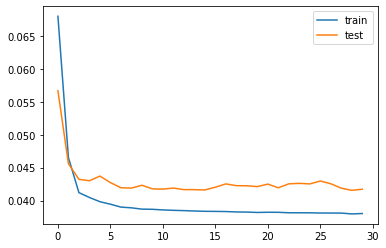

In [ ]:
# design network
err_train,err_test = list(),list()
model = keras.Sequential()
#model.add(Bidirectional(LSTM(35, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2]), merge_mode='concat'))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
for i in range(40):
  history = model.fit(train_X, train_y, epochs=1, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  err_test.append(history.history['val_loss'])
  err_train.append(history.history['loss'])
  print(i)
  model.reset_states()
  # plot history
print(err_train)
plt.plot(err_train, label='train')
plt.plot(err_test, label='test')
plt.legend()
plt.show()

[[31.199997]
 [29.350006]
 [27.149994]
 ...
 [24.375   ]
 [28.45    ]
 [28.425   ]] [[33.001133]
 [30.493765]
 [28.937012]
 ...
 [27.167028]
 [24.48709 ]
 [31.261374]]


error values for LSTM predictions:
	Mean Absolute Error: 2.4683042046260226
	Mean Squared Error: 10.678108019987173
	Root Mean Squared Error: 3.267737446611519


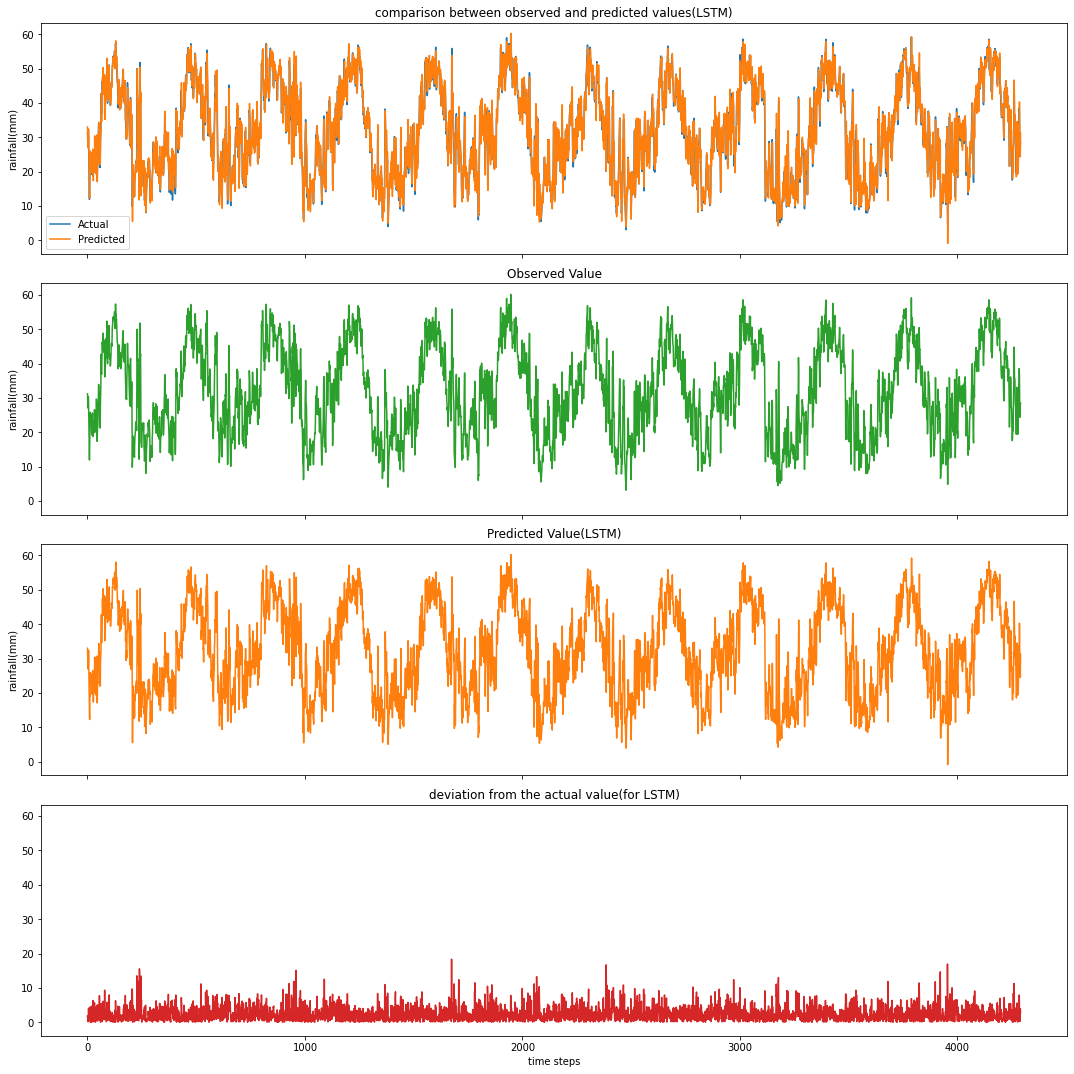

In [ ]:
# make a prediction
yhat = model.predict(test_X)
#yhat = scaler.inverse_transform(yhat)
#test_X = test_X.reshape((test_X.shape[0], 21))
# invert scaling for actual
test_y = y_scaler.inverse_transform(test_y)
yhat = y_scaler.inverse_transform(yhat)

test_y = test_y.reshape((len(test_y), 1))

print(test_y,yhat)

# calculate errors
print("\n\nerror values for LSTM predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y, yhat))
print('\tMean Squared Error:', metrics.mean_squared_error(test_y, yhat))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, yhat)))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax0.plot(test_y)
ax0.plot(yhat)
ax0.set_title('comparison between observed and predicted values(LSTM)')
ax0.legend(['Actual','Predicted'])
ax0.set_ylabel('rainfall(mm)')
ax1.plot(test_y, 'tab:green')
ax1.set_ylabel('rainfall(mm)')
ax1.set_title('Observed Value')
ax2.plot(yhat, 'tab:orange')
ax2.set_ylabel('rainfall(mm)')
ax2.set_title('Predicted Value(LSTM)')
ax3.plot(abs(test_y-yhat), 'tab:red')
ax3.set_title('deviation from the actual value(for LSTM)')
ax3.set_xlabel('time steps')
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig.tight_layout(pad=1.0)
plt.show()

#fig = plt.subplots(1)
#print(list(range(0,df.shape[0]-n_train,200)),np.array(df_init.iloc[list(range(n_train,df.shape[0],200)),0]))



yhat is the series predicted by LSTM

yhat[:,2] is the rainfall value predicted by LSTM

Humidity_data    729.237464
Air_data          16.216020
rainfall         158.107022
dtype: float64


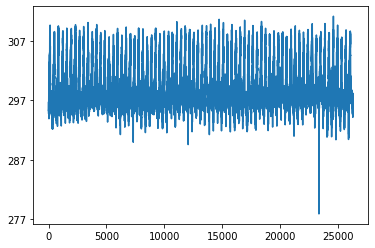

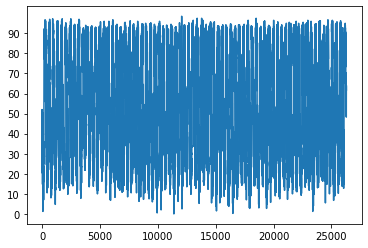

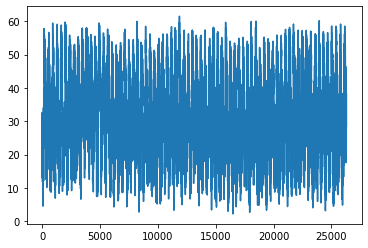

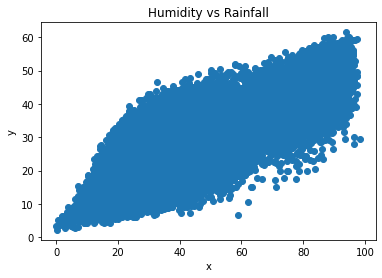

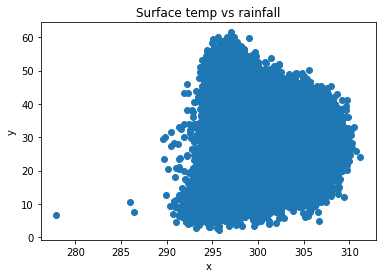

In [ ]:
print(init_data.var())

plt.plot(init_data['Air_data'])
plt.yticks(list(range(int(init_data['Air_data'].min()),int(init_data['Air_data'].max()),10)))
plt.show()
plt.plot(init_data['Humidity_data'])
plt.yticks(list(range(0,int(init_data['Humidity_data'].max()),10)))
plt.show()
plt.plot(init_data['rainfall'])
plt.yticks(list(range(0,int(init_data['rainfall'].max()),10)))
plt.show()
plt.scatter(init_data['Humidity_data'], init_data['rainfall']) 
plt.xlabel('x') 
plt.ylabel('y') 
plt.title("Humidity vs Rainfall") 
plt.show()
plt.scatter(init_data['Air_data'], init_data['rainfall']) 
plt.xlabel('x') 
plt.ylabel('y') 
plt.title("Surface temp vs rainfall")
plt.show() 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(init_data.iloc[:,0:2], init_data.iloc[:,2], test_size=0.2)
print(y_test.shape)
#X_train, y_train = np.asarray(init_data.iloc[:,0:2]), np.asarray(init_data.iloc[:,2])
#X_test = yhat[:,:2]
print(X_train,X_train.shape)

(5260,)
       Humidity_data   Air_data
18087      89.500000  297.37000
19928      80.750000  297.07000
5458       55.259995  295.21002
9274       28.750000  306.96002
13819      37.510010  297.05000
...              ...        ...
6460       82.509995  296.47998
13388      88.009995  296.47998
15586      83.509995  296.47998
14116      75.509995  297.24000
25722      50.750000  303.55000

[21038 rows x 2 columns] (21038, 2)


X_test contains 6291 samples of humidity and air data predicted by LSTM

**Prediction using Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_lr = regressor.predict(X_test)
df_lr = pd.DataFrame({'Actual': y_test ,'Predicted': y_pred_lr})
df_lr

,Actual,Predicted
7154,53.130005,47.236325
13063,51.679993,49.696450
17768,44.509995,48.787043
21681,25.569992,26.771108
9329,52.780000,45.505753
...,...,...
18830,49.940002,45.765214
7704,16.829987,19.714654
16637,40.610000,44.180575
13732,50.459990,47.794143


y_pred_lr is the rainfall value predicted using Linear Regression

In [ ]:
print("error values for LinearRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y, yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for LinearRegression predictions:
	Mean Absolute Error: 3.40147994248176
	Mean Squared Error: 18.87695005720422
	Root Mean Squared Error: 4.344761219814528


**prediction using Multiple Linear Regression**

In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_mlp = regr.predict(X_test)
df_mlp = pd.DataFrame({'Actual': y_test,'Predicted': y_pred_mlp})
df_mlp

,Actual,Predicted
7154,53.130005,48.028456
13063,51.679993,50.034042
17768,44.509995,48.065920
21681,25.569992,21.057788
9329,52.780000,46.472301
...,...,...
18830,49.940002,45.749572
7704,16.829987,23.208824
16637,40.610000,42.359730
13732,50.459990,48.236552


In [ ]:
print("error values for MLPRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_mlp))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_mlp))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlp)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y[:,2], yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for MLPRegression predictions:
	Mean Absolute Error: 5.364437498723341
	Mean Squared Error: 43.54664908559409
	Root Mean Squared Error: 6.598988489578845


**prediction using Support Vector Regression**

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = init_data.shape[0], 2
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
#Pipeline(steps=[('standardscaler', StandardScaler()),('svr', SVR(epsilon=0.2))])
y_pred_svr = regr.predict(X_test)
df_svr = pd.DataFrame({'Actual':y_test,'Predicted': y_pred_svr})
df_svr

,Actual,Predicted
7154,53.130005,48.026020
13063,51.679993,49.425885
17768,44.509995,48.166764
21681,25.569992,24.846430
9329,52.780000,46.498456
...,...,...
18830,49.940002,46.111683
7704,16.829987,20.358262
16637,40.610000,43.751591
13732,50.459990,48.272835


In [ ]:
print("error values for SVRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_svr))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_svr))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))

#print("\n\nerror values for LSTM predictions:")
#print('\tMean Absolute Error:', metrics.mean_absolute_error(test_y[:,2], yhat[:,2]))
#print('\tMean Squared Error:', metrics.mean_squared_error(test_y[:,2], yhat[:,2]))
#print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y[:,2], yhat[:,2])))

error values for SVRegression predictions:
	Mean Absolute Error: 3.090655767809063
	Mean Squared Error: 16.38507406218488
	Root Mean Squared Error: 4.04784807795264


In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train,y_train)
y_pred_ridge = reg.predict(X_test)
df_ridge = pd.DataFrame({'Actual':y_test,'Predicted': y_pred_ridge})
df_ridge

,Actual,Predicted
7154,53.130005,47.236323
13063,51.679993,49.696446
17768,44.509995,48.787036
21681,25.569992,26.771088
9329,52.780000,45.505752
...,...,...
18830,49.940002,45.765210
7704,16.829987,19.714661
16637,40.610000,44.180568
13732,50.459990,47.794140


In [ ]:
print("error values for SVRegression predictions:")
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

error values for SVRegression predictions:
	Mean Absolute Error: 3.4014802030809355
	Mean Squared Error: 18.876951691488912
	Root Mean Squared Error: 4.344761407889841


In [ ]:
'''
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5,sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
#fig.suptitle('Rainfall Forecast')
ax0.plot(test_y[:,2])
ax0.plot(yhat[:,2])
ax0.set_title('comparison between observed and predicted values(LSTM)')
ax0.legend(['Actual','Predicted'])
ax0.set_ylabel('rainfall(mm)')
ax1.plot(test_y[:,2], 'tab:green')
ax1.set_ylabel('rainfall(mm)')
ax1.set_title('Observed Value')
ax2.plot(yhat[:,2], 'tab:orange')
ax2.set_ylabel('rainfall(mm)')
ax2.set_title('Predicted Value(LSTM)')
#ax3.plot(abs(test_y[:,2]-yhat[:,2]), 'tab:red')
#ax3.set_title('deviation from the actual value(for LSTM)')
ax3.plot(y_pred_lr, 'tab:grey')
ax3.set_ylabel('rainfall(mm)')
ax3.set_title('Predicted Value(Linear Regression)')
ax4.plot(y_pred_svr, 'tab:cyan')
ax4.set_ylabel('rainfall(mm)')
ax4.set_title('Predicted Value(SVRegression)')
ax4.set_xlabel('time steps')
#plt.xticks(list(range(0,init_data.shape[0],400)))
fig.tight_layout(pad=1.0)
plt.show()
'''

"\nfig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5,sharex=True, sharey=True)\nfig.set_figheight(15)\nfig.set_figwidth(15)\n#fig.suptitle('Rainfall Forecast')\nax0.plot(test_y[:,2])\nax0.plot(yhat[:,2])\nax0.set_title('comparison between observed and predicted values(LSTM)')\nax0.legend(['Actual','Predicted'])\nax0.set_ylabel('rainfall(mm)')\nax1.plot(test_y[:,2], 'tab:green')\nax1.set_ylabel('rainfall(mm)')\nax1.set_title('Observed Value')\nax2.plot(yhat[:,2], 'tab:orange')\nax2.set_ylabel('rainfall(mm)')\nax2.set_title('Predicted Value(LSTM)')\n#ax3.plot(abs(test_y[:,2]-yhat[:,2]), 'tab:red')\n#ax3.set_title('deviation from the actual value(for LSTM)')\nax3.plot(y_pred_lr, 'tab:grey')\nax3.set_ylabel('rainfall(mm)')\nax3.set_title('Predicted Value(Linear Regression)')\nax4.plot(y_pred_svr, 'tab:cyan')\nax4.set_ylabel('rainfall(mm)')\nax4.set_title('Predicted Value(SVRegression)')\nax4.set_xlabel('time steps')\n#plt.xticks(list(range(0,init_data.shape[0],400)))\nfig.tight_layout(pad=1.